# Part 2: Simple Text Processing - Tokenization, Lemmatization, Word Frequency, Vectorization

## Processing Speeches with SpaCy

The data used for this project is primarily read in via the package SpaCy as demonstrated below. Once the file has been read in, a portion of the data inlcuding entries from the year 2000 and later will be filtered out for some basic analysis practices involving tokens and lemmas. Tokens are single words or pieces of words and lemmas are core component or root of the words in the data set. 

In [2]:
#import packages
import spacy
from tqdm import tqdm
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

nlp = spacy.load("en_core_web_sm")

In [3]:
# read in data and subset for speeches for years 2000 and beyond
sotu = pd.read_csv('data/SOTU.csv')
filtered_sotu = sotu[sotu['Year'] >= 2000.0]

In [4]:
# process speeches into text in a list format
text = []

for doc in tqdm(filtered_sotu['Text']):
    words = nlp(doc)
    text.append(words)

100%|██████████| 25/25 [00:22<00:00,  1.10it/s]


### Tokens vs Lemmas

A first look at analysis for this data comes in the form of comparing the top 25 tokens and lemmas for the entire data set. These tokens and lemmas shouldn't include stop words, punctuation, or spaces. For the case of this filtering, I have also opted to filter out currency characters, however they will remain included in future sections of this portion of the overall project.

In [5]:
# start with a single speech tokens
tokens_test = []
lemmas_test = []

for t in text[0]:
    if t.is_stop == False and t.is_punct == False and t.is_space == False and t.is_currency == False:
            tokens_test.append(t.lower_)
            lemmas_test.append(t.lemma_.lower())

In [6]:
# expand method to full set of text
tokens = []
lemmas = []

for doc in tqdm(text):
    for t in doc:
        if t.is_stop == False and t.is_punct == False and t.is_space == False and t.is_currency == False:
            tokens.append(t.lower_)
            lemmas.append(t.lemma_.lower())

100%|██████████| 25/25 [00:00<00:00, 182.80it/s]


In [7]:
# look at top 25 tokens
top_tokens = Counter(tokens).most_common(25)
top_tokens

[('america', 816),
 ('people', 637),
 ('american', 582),
 ('new', 530),
 ('years', 439),
 ('americans', 437),
 ('world', 425),
 ('year', 406),
 ('country', 369),
 ('jobs', 348),
 ('tonight', 344),
 ('work', 324),
 ('know', 323),
 ('let', 320),
 ('congress', 317),
 ('nation', 311),
 ('time', 301),
 ('help', 282),
 ('need', 266),
 ('tax', 255),
 ('president', 247),
 ('economy', 243),
 ('like', 241),
 ('right', 240),
 ('want', 237)]

In [8]:
# look at top 25 lemmas
top_lemmas = Counter(lemmas).most_common(25)
top_lemmas

[('year', 845),
 ('america', 816),
 ('people', 639),
 ('american', 587),
 ('work', 557),
 ('new', 532),
 ('job', 486),
 ('country', 435),
 ('americans', 432),
 ('world', 426),
 ('know', 395),
 ('nation', 388),
 ('help', 378),
 ('need', 353),
 ('time', 351),
 ('tonight', 344),
 ('child', 332),
 ('let', 326),
 ('congress', 317),
 ('come', 301),
 ('family', 296),
 ('good', 294),
 ('right', 282),
 ('million', 274),
 ('want', 264)]

/tmp/ipykernel_210/4202296752.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(top_token_df['tokens'], rotation=45, ha='right')
/tmp/ipykernel_210/4202296752.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(top_lemma_df['lemmas'], rotation=45, ha='right')


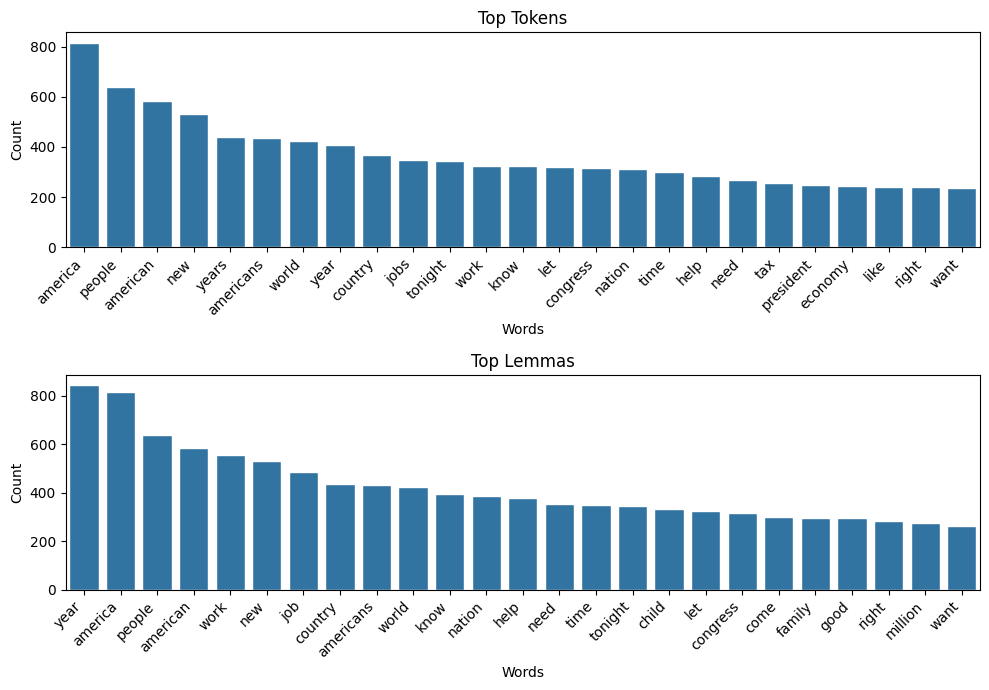

In [9]:
# extract info from top_tokens/top_lemmas lists
tokens, token_counts = zip(*top_tokens)
lemmas, lemma_counts = zip(*top_lemmas)

top_token_df = pd.DataFrame({
    'tokens': tokens,
    'token_counts': token_counts
})

top_lemma_df = pd.DataFrame({
    'lemmas': lemmas,
    'lemma_counts': lemma_counts
})

# plot the top tokens/lemmas to visualize a direct comparison
fig, axs = plt.subplots(2, 1, figsize = (10, 7))

sns.set_style('dark')
sns.barplot(top_token_df, x = top_token_df['tokens'], y = top_token_df['token_counts'], ax = axs[0])
axs[0].set_title('Top Tokens')
axs[0].set_xlabel('Words')
axs[0].set_ylabel('Count')
axs[0].set_xticklabels(top_token_df['tokens'], rotation=45, ha='right') 

sns.barplot(top_lemma_df, x = top_lemma_df['lemmas'], y = top_lemma_df['lemma_counts'], ax = axs[1])
axs[1].set_title('Top Lemmas')
axs[1].set_xlabel('Words')
axs[1].set_ylabel('Count')
axs[1].set_xticklabels(top_lemma_df['lemmas'], rotation=45, ha='right')

plt.savefig("outputs/top_tokens_vs_lemmas.png")

plt.tight_layout()
plt.show()

### Token vs Lemma Comparison

The plot above shows the distributions for the top 25 tokens and the top 25 lemmas. In general, they are distributed very similarly, which is something one would expect to some degree. The actual words themselves very in placement such as the tokens "year" and "years" compared to the lemma "year." The tokens for these two words are just shy of 400 in frequency while "year" in the lemma plot is just about 800 in frequency. This makes sense as lemma will combine words with the same base principles. Other words such as "child" appear only in the lemma plot as the top tokens list is filled with words that share the same root, but due to being tokens they are not lumped together like they are in the lemma figure.

## Common Words

To explore common words in the data further, a function can be developed that takes in the initial dataframe and produces the top values for any given year.

In [10]:
# build function for common lemmas

def get_most_common_words(df, year, n=25):
    """
    Processes the SOTU speech for a given year and returns
    the most common non-stopword/punctuation lemmas.
    """
    # subset the df for the specified year
    df = df[df['Year'] == year]

    # process text
    lemmas = []
    
    for i in tqdm(range(len(df))):
        text = df['Text'].iloc[i]
        tokens = nlp(text)
        for token in tokens:
            if token.is_stop == False and token.is_punct == False and token.is_space == False:
                lemmas.append(token.lemma_.lower())

    top_lemmas = Counter(lemmas).most_common(n)

    return top_lemmas

In [11]:
get_most_common_words(sotu, 2024.0)

100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


[('president', 58),
 ('year', 45),
 ('america', 44),
 ('american', 34),
 ('people', 33),
 ('$', 33),
 ('member', 32),
 ('want', 29),
 ('audience', 29),
 ('know', 29),
 ('pay', 29),
 ('come', 26),
 ('home', 25),
 ('family', 24),
 ('future', 23),
 ('million', 23),
 ('like', 21),
 ('build', 21),
 ('laughter', 20),
 ('americans', 20),
 ('history', 19),
 ('world', 19),
 ('right', 19),
 ('tax', 19),
 ('house', 18)]

To test this fucntion, it can be run through with a year input of 2024 as shown above with the top 25 words in the data. In this case we want to use the lemma model since words with the same base should be lumped together due to similarities in sentiment.

### Compare 2023 and 2019 top words

This function is utilized using data for the years 2023 and 2019 to perfom some basic comparitive analysis. In this case the top 10 lemmas will be compared vsiually using a bar graph.

In [30]:
# use defined function to pull the top words for 2023 and 2019
words_2023 = get_most_common_words(sotu, 2023.0, n=10)
words_2019 = get_most_common_words(sotu, 2019.0, n=10)

# set up the lists in data frame form for convenience of plotting like before
lemmas_2023, lemma_counts_2023 = zip(*words_2023)
lemmas_2019, lemma_counts_2019 = zip(*words_2019)

df_2023 = pd.DataFrame({
    'lemmas': lemmas_2023,
    'lemma_counts': lemma_counts_2023
})

df_2019 = pd.DataFrame({
    'lemmas': lemmas_2019,
    'lemma_counts': lemma_counts_2019
})

100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


In [31]:
# show counts by displaying both data frames
df_2023

,lemmas,lemma_counts
0,year,58
1,go,56
2,let,45
3,know,40
4,people,39
5,job,38
6,america,36
7,come,33
8,law,33
9,pay,33


In [32]:
df_2019

,lemmas,lemma_counts
0,year,38
1,american,34
2,thank,29
3,america,25
4,new,22
5,states,19
6,tonight,19
7,country,19
8,americans,18
9,united,17


/tmp/ipykernel_210/2673021819.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(df_2019['lemmas'], rotation=45, ha='right')
/tmp/ipykernel_210/2673021819.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(df_2023['lemmas'], rotation=45, ha='right')


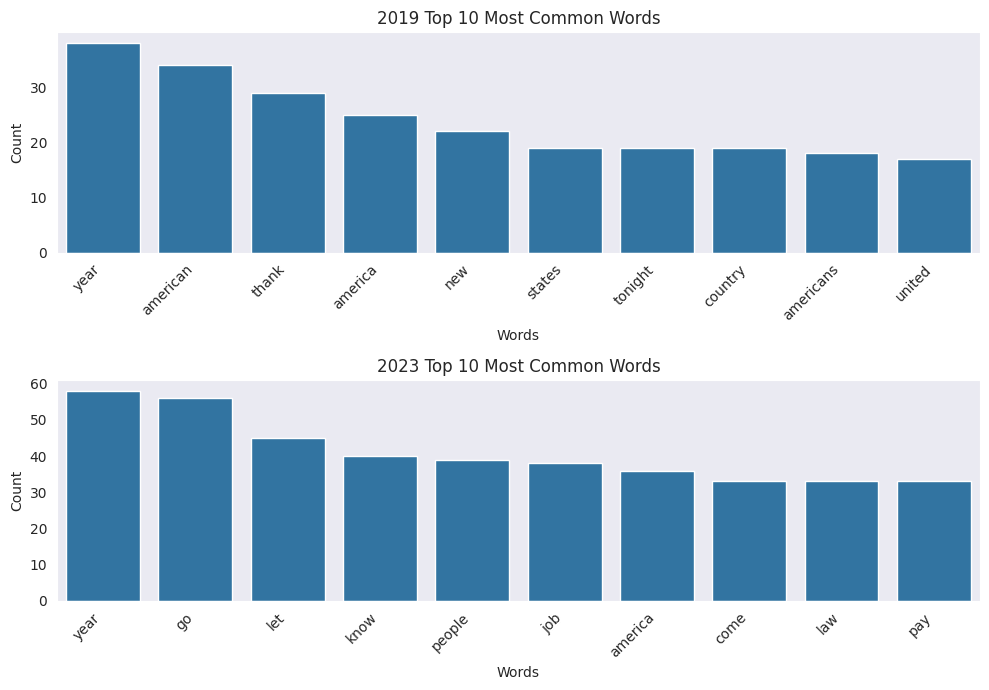

In [33]:
# make plots with seaborn

fig, axs = plt.subplots(2, 1, figsize = (10, 7))

sns.set_style('dark')
sns.barplot(df_2019, x = df_2019['lemmas'], y = df_2019['lemma_counts'], ax = axs[0])
axs[0].set_title('2019 Top 10 Most Common Words')
axs[0].set_xlabel('Words')
axs[0].set_ylabel('Count')
axs[0].set_xticklabels(df_2019['lemmas'], rotation=45, ha='right') 

sns.barplot(df_2023, x = df_2023['lemmas'], y = df_2023['lemma_counts'], ax = axs[1])
axs[1].set_title('2023 Top 10 Most Common Words')
axs[1].set_xlabel('Words')
axs[1].set_ylabel('Count')
axs[1].set_xticklabels(df_2023['lemmas'], rotation=45, ha='right')

plt.savefig("outputs/2019_vs_2023_commonwords.png")

plt.tight_layout()
plt.show()

The plot above shows the distribution of word roots or lemmas, similarly to the Tokens vs Lemmas plot from earlier. 

## TF-IDF Vectorization

For more in depth analysis, the data must be converted into a vectorized form by following the TF-IDF embedding process. This process takes the data and transforms it to give it a score. The IDF score for a given word shows how rare or common it is among a collection of texts, TF-IDF then shows the importance of the word within a given speech relative to the rest of the speeches. 

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

To start, I worked with just the smaller subset of the data for the years 2000 and above to get a general idea of what each step in the process looked like.

In [17]:
# collect raw text from a smaller portion of data to test idea (use filtered_sotu)
raw_filtered = filtered_sotu['Text'].to_list()

In [18]:
# set up vectorizor and run through fit_transform then reduce by running PCA through fit_transform to narrow down number of words
vectorizer = TfidfVectorizer(stop_words = 'english')
raw_matrix = vectorizer.fit_transform(raw_filtered).toarray()

pca = PCA(n_components=10)
reduced_matrix = pca.fit_transform(raw_matrix)

reduced_matrix.shape

(25, 10)

To make things easier, I wrote a function to vectorize the data as well as to extract a PCA code. The PCA reduces the number of overall components for better plotting and reduced data analysis.

In [20]:
# make a function for vectorizing and pca

def tfidf_pca(data, n = 10):
    """inputs:
        - data: read in data 
        - n: number of components for pca

        outputs:
        - raw_matrix: matrix with speeches for rows and tokens for columns and values = tf-idf scores
        - reduced_matrix: matrix with speeches for rows and reduced components for columns and values = tf-idf scores
    """
    text = data['Text'].to_list()
    
    vectorizer = TfidfVectorizer() # stop words not removed
    raw_matrix = vectorizer.fit_transform(text).toarray()
    
    pca = PCA(n_components = n)
    reduced_matrix = pca.fit_transform(raw_matrix)

    return raw_matrix, reduced_matrix

In [21]:
# run the full data set through function and convert to dataframe for plotting

vect_matrix, pca_matrix = tfidf_pca(sotu, n = 2)

pca_df = pd.DataFrame(
    pca_matrix,
    columns=["PC1", "PC2"]
)

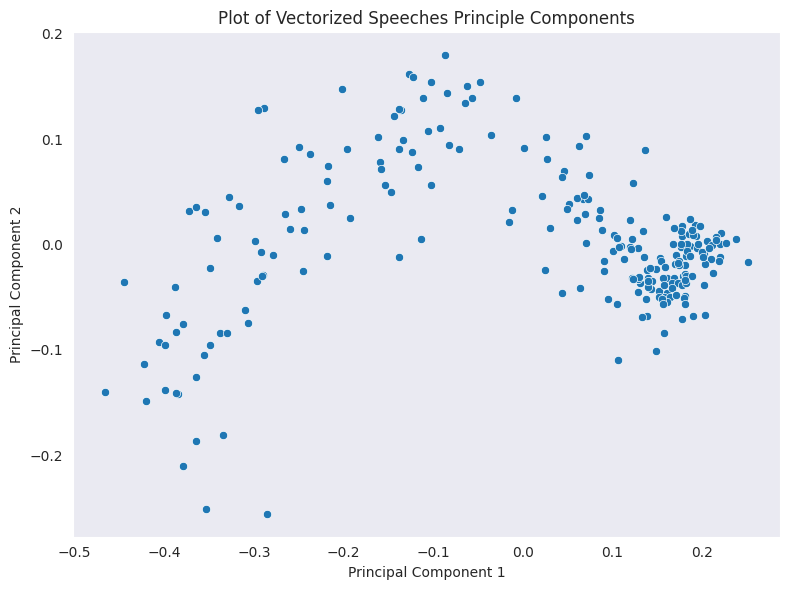

In [22]:
plt.figure(figsize=(8,6))
sns.set_style('dark')
sns.scatterplot(x = 'PC1', y = 'PC2', data = pca_df)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Plot of Vectorized Speeches Principle Components")

plt.savefig("outputs/principle_components.png")

plt.tight_layout()
plt.show()


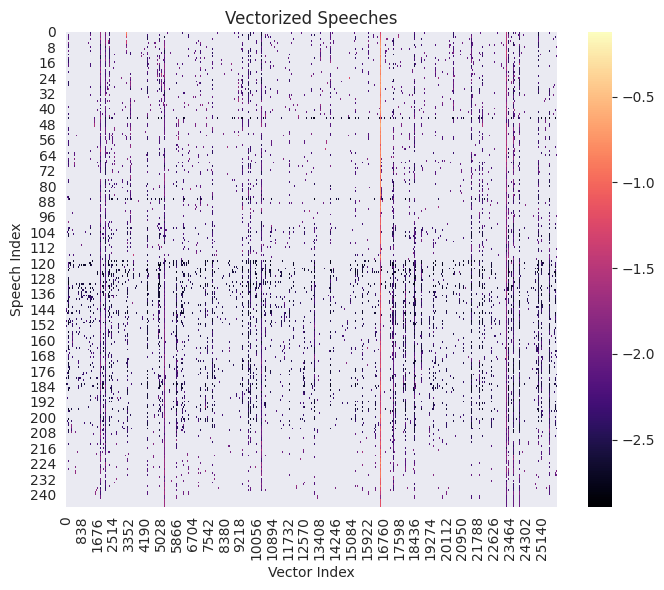

In [23]:
# to plot speech index vs vector index make new data frame
index_df = pd.DataFrame(
    vect_matrix,
    index=range(vect_matrix.shape[0]),          # speech indices
    columns=range(vect_matrix.shape[1])         # vector indices
)

# take log (add on a small constant to avoid approaching log(0)
log_index_df = np.log10(index_df + 1e-3)

# get rid of the many values at 0
masked_matrix = np.where(vect_matrix == 0, np.nan, vect_matrix)

# plot heatmap
plt.figure(figsize=(7, 6))
sns.set_style('dark')
sns.heatmap(
    log_index_df,
    cmap="magma",
    linewidths=0.0,
    mask = np.isnan(masked_matrix)
)

plt.savefig("outputs/vectorized_heatmap.png")

plt.title("Vectorized Speeches")
plt.xlabel("Vector Index")
plt.ylabel("Speech Index")
plt.tight_layout()
plt.show()


The scatter plot above compares the top two principle components and the heatmap shows the logatithmic distribution of the indices for the speeches themselves and the vectors.

### Get the TF-IDF value for certain words and documents

The TF-IDF score can also be calculated and viewed for a specific set of words. In this case, a set of words has been selected for analysis and are shown below.

In [24]:
word_list = ['year',
 'america',
 'people',
 'american',
 'work',
 'new',
 'job',
 'country',
 'americans',
 'world'] # top ten most common words through whole corpus

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

# get index values for word list
idx_vectorizer = CountVectorizer()
idx_vectorizer.fit(sotu['Text'].to_list())

word_nums = {}
for word in word_list:
    idx = idx_vectorizer.vocabulary_.get(word)
    word_nums[word] = idx

word_nums

{'year': 25879,
 'america': 2410,
 'people': 17259,
 'american': 2412,
 'work': 25728,
 'new': 15972,
 'job': 13576,
 'country': 6506,
 'americans': 2416,
 'world': 25753}

In [28]:
# get idf values for the specific words in the word list

idf_vectorizer = TfidfVectorizer()
idf_vectorizer.fit_transform(sotu['Text'].to_list())

idf_score = []
for word in word_list:
    idx = word_nums[word]
    idf = idf_vectorizer.idf_[idx]
    idf_score.append(idf)

In [29]:
# get tf-idf values for first speech and present in data frame
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(sotu['Text'].to_list())

# look at first doc in particular
tfidf_extract = tfidf[0].toarray().flatten()

tf_idf = []
for word in word_list:
    idx = word_nums[word]
    tf_idf.append(tfidf_extract[idx])

In [33]:
pd.DataFrame({"Word": word_list, "IDF Score": idf_score, "TF-IDF Score": tf_idf})

,Word,IDF Score,TF-IDF Score
0,year,1.032925,0.022719
1,america,1.272946,0.068439
2,people,1.037118,0.043087
3,american,1.102217,0.045792
4,work,1.162281,0.005681
5,new,1.024591,0.016275
6,job,2.043480,0.009988
7,country,1.008130,0.013550
8,americans,1.713598,0.041877
9,world,1.138750,0.026438


The process shown above demonstrates using the index value of the word as it would be in the resulting vectorized matrix to call the specific IDF and TF-IDF scores for each of the selected words. The results of this are shown in the dataframe above.